# Prerequisite
attention mechanism \
seq2seq

# 트랜스포머의 하이퍼 파라미터


dimension of embedding = 512    :     512차원을 갖는다 \
num_layers = 6 : 인코더 디코더를 얼마나 많이 쌓을 것인가 \
num_heads = 8 : 인코딩때 몇가징 시각으로 문제를 볼것인가



**트랜스포머가 등장한 이유** : seq2seq의 문제는 seq 길이가 길어지면 정보 손실이 일어나는 문제가 있다. 그렇다면 seq을 사용하지 않는 방법론을 생각하다가 enc-dec으로만 기존의 문제를 해결할 수 없을까라는 생각을 하였다. <br>
**seq2seq과 차이점** : seq은 t의 시간성을 가지는 구조였다면, transformer는 enc-dec구조가 n개 있다는 점이 차별점이다. 논문에서는 6개의 enc-dec를 사용하였다.


## 1. 포지셔날 인코딩
seq모델과는 다르게 시간성이 없어진 모델이다. 그렇다면 단어들간의 시간성, 순서성을 어떻게 넣어줄까? <br>
=> 포지셔날 인코딩이라는 개념을 사용하였다. <br>

구체적으로 방법론을 이야기 하자면, word embedding후 positional encoding을 하였다. <br>
<br>
$PE_{(pos,2i)} =\sin(pos/10000^{2i/dmodel})$

$PE_{(pos,2i+1)} =\cos(pos/10000^{2i/dmodel})$

여기서 pos는 몇번째 단어인지, i는 몇번째 embedding인지, dmodel은 embedding의 차원수 이다. <br>
이렇게 포지셔널 인코딩 값을 더하면 같은 단어라도 문장내의 위치에 따라 벡터 값이 달라진다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        '''
        클래스의 인자로 포지션과, 임베딩 차원의 크기를 받는다.
        '''
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        '''sin,cos을 하기전 computations'''
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
                position = tf.range(position, dtype=tf.float32)[:, tf.newaxis], # 0,1,...,position with shape [position,1]
                i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],         # 0,1,...,dim with shape [1, dim]
                d_model = d_model)
                # returning [position, dim] metrix b/c broadcasting
        
        
        # emb-dim배열의 짝수 인덱스(2i)에는 사인 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])

        # emb-dim배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])


        angle_rads = np.zeros(angle_rads.shape)
        angle_rads[:, 0::2] = sines
        angle_rads[:, 1::2] = cosines
        pos_encoding = tf.constant(angle_rads)       # numpy array -> tensorflow tensor
        pos_encoding = pos_encoding[tf.newaxis, ...] # [position, dim] => [1, position, dim]  // b/c input shape is 3d tensor

        print(pos_encoding.shape)
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

## Positional encoding을 시각화 해보자

(1, 100, 512)


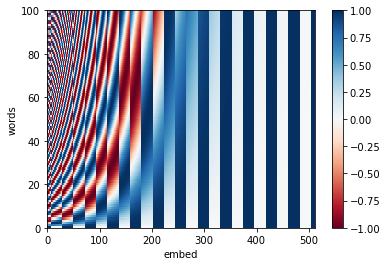

In [2]:
test_positional_enc = PositionalEncoding(100, 512) # 100 words, 512 embed
plt.pcolormesh(test_positional_enc.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('embed')
plt.xlim((0, 512))
plt.ylabel('words')
plt.colorbar()
plt.show()

## Self-Attention
attention은 query, key, value가 필요한데 dot product, banadau attention같은 경우 query가 dec의 state vector이고, key,value가 enc의 vector였다. 하지만 self-attention은 query,key,value모두 enc에서 나온 정보로 쓴다.

$Attention(Q, K, V ) = \text{softmax}\left(\dfrac{QK^T}{\sqrt{d_k}}\right)V$

<img src="./png/attention_part.jpg" width = '500' height = '1000'><br>
transforemr에서는 enc에서 한번, dec에서 두번 self-attention을 쓴다

# Encoder
논문에서는 6개의 인코더층을 쌓았다. 하나의 인코더 층에는 multi-head attention과 FFN층 두개로 이루어짐. 먼저 multi-head attention을 살펴보자

### Self Attention
multihead attention을 살펴보기 전에 self attention을 먼저 살펴보자<br>
기본적으로 attention은 query와 key간의 유사도를 구하고 value에 가중치를 반영해준다.<br>
바나다우 어텐션을 생각해보면 query(dec-state)과 key(enc-vector)간의 유사도를 구하고 value(enc-vector)에 가중치를 반영하여 사용했다.<br>
셀프 어텐션에서는 enc와 enc사이의 관계를 파악한다. 이로서 생기는 장점은 아래와 같다<br>
<img src="./png/self_att.png"><br>
여기서 it에 해당하는것은 street인지, animal인지 기계는 햇갈릴수 있다. self-attention을 통해 문장 내 단어들끼리 유사도를 찾아 it이 animal이 연관되었을 확률이 높다는 것을 찾게 유도한다. 

### Q,K,V는??
위에서 설명한 것처럼 self-attention의 q,k,v는 모두 enc의 정보를 가지고 한다고 하였다. 그렇다면 구체적으로 어떻게 하는가?<br>
논문에서는 embedding_size가 512였다. 그리고 heads의 갯수가 8개여서 하나의 head는 64개의 embed size를 감당하게 된다.(512->64개로 만들어 줘야한다)<br>

예를들어: <br>

animal의 경우 [1,512]의 쉐입을 갖는다. 여기서 q,k,v를 각각 구하는데, 64개로 차원을 축소해야하니 [512,64]를 갖는 웨이트W를 곱해준다.<br>
결과적으로 [1,64]를 갖는 행렬을 구할 수 있다. 

<img src="./png/Q,K,V.jpg" width = '500' height = '500'><br>
이것을 한번에 처리하는 모습은 다음과 같다<br>
<img src="./png/Q,K,V2.jpg" width = '500' height = '500'><br>
<br>
어텐션 식에 의하면 <br>
$Attention(Q, K, V ) = \text{softmax}\left(\dfrac{QK^T}{\sqrt{d_k}}\right)V$<br>
<img src="./png/Q,K,V3.jpg" width = '500' height = '500'><br>

## Self-attention Code Part

In [3]:
def scaled_dot_attention(query, key, value, mask):
    '''
    query : (batch, num_heads, words, emb_dim/num_heads)
    key : (batch, num_heads, words, emb_dim/num_heads)
    value : (batch, num_heads, words, emb_dim/num_heads)
    padding : (batch, 1, 1, words)
    '''
    
    # Q*K_transopse
    QK = tf.matmul(query, key, transpose_b = True) # [batch, 8, n, 64] * [batch, 8, 64, n] = [batch, 8, n, n]
    
    # QK/sqrt(d)
    d = tf.cast(tf.shape(key)[-1], tf.float32)
    inside = QK/tf.math.sqrt(d) # attention score [batch, 8, n, n]
    
    # masking : 어텐션 스코어에 마스킹 할 위치에 매우 작은 음수값을 넣는다., 매우 작은 값이라 소프트맥스 함수를 지나면 0이 된다
    if mask is not None:
        inside += (mask * -1e9)
    
    attention_distribution = tf.nn.softmax(inside, axis = -1) 
    
    # 최종 output
    output = tf.matmul(attention_distribution, value)  # [batch, 8, n,n] * [batch, 8, n, 64] = [batch, 8, n, 64]
    
    return output, attention_distribution # [batch, 8, n, 64]

#### 참고 softmax 의 axis
https://www.tensorflow.org/api_docs/python/tf/nn/softmax 를 살펴보면 <br>
**softmax = tf.exp(logits) / tf.reduce_sum(tf.exp(logits), axis)** 라고 나와있다. axis 는 reduce_sum 메서드에 의해 좌지우지 되는데, reduce_sum문서를 살펴보면 pandas의 axis와 비슷한 방법론으로 사용됨을 알 수 있다.

#### **mask의 목적**
NLP를 하면서 하나의 문장에 몇개의 단어를 포함할지 정한다. 단어의 수가 모자르면 padding을 해서 0으로 채워준다. <br>
mask의 역할은 pad가 있을경우 어텐션에서 제외하기 위함이다.<br>
<img src="./png/mask.jpg" width = '1000' height = '1000'><br>

### mask 구현하기
mask를 구현하는 핵심 생각은 padding인지 아닌지 구분해야 한다. 의미를 갖는 단어인 경우 0을 padding인 경우에는 1을 도출하는 함수를 만들자

In [4]:
def create_padding_mask(x):
    '''
    pad인곳은 1을 단어가 잇는 부분은 0을 return 하는 함수
    x : 시퀀스 텐서  
        예) [[[[1, 2, 3, 0, 0]]]]    여기서 0은 padding data
            return : [[[[0, 0, 0, 1, 1]]]]
    '''
    
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)  
    return mask[:, tf.newaxis, tf.newaxis, :]  # inside와 더해져야 하므로 차원을 맞춰줘야 한다. inside의 shape은 [batch, 8, n, 64]

## Multi-head Attention
논문에서는 512개의 embedding size를 갖고 8개의 head를 갖는다 하였다. 그래서 512개의 차원을 8로 나누어 64차원의 Q,K,V로 나누어 어텐션을 수행하였다. 논문에 의하면 512개로 한번하는 어텐션보다, 여러 방면에서 바라보는 어텐션이 효과적이다라는 것을 밝혔다. 그렇다면 8개로 나누어 살펴보면 어떤점에서 좋은지 간략한 예를 통해서 설명해 보겠다. the animal didn't cross the street because it was too tired 라는 문장에서 it은 animal이 될수도, tired이 될수도 있다. 따라서 각기 가중치가 다른 헤드로 여러 방면으로 문장관의 관계를 살피는 이점이 있다. 8개의 시점으로 살펴본 것을 concat하면 512인 원본 사이즈로 돌아온다. 그리고 마지막으로 W를 곱하여 multi-head attention을 완성한다.<br>
<img src="./png/multi-head.jpg" width = '1000' height = '1000'><br>

### multihead attention code

In [5]:
class Multi_Head_Attention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, heads, name = 'Multi_Head_Attention'):
        '''
        d_model : dimension of model, in this case embed size
        heads : 8 according to paper
        '''
        super(Multi_Head_Attention, self).__init__(name = name)
        self.heads = heads
        self.d_model = d_model
        
        # dim 이 head수로 안떨어지면 에러
        assert d_model % heads == 0, 'change number of heads'
        
        # calculate size per head
        self.part_dim = d_model//heads
        
        # WQ, WK, WV, WO 정의
        self.query_w = tf.keras.layers.Dense(units = d_model) # 512
        self.key_w = tf.keras.layers.Dense(units = d_model)
        self.value_w = tf.keras.layers.Dense(units = d_model)
        self.out_w = tf.keras.layers.Dense(units = d_model)
        
    
    def split_heads(self, inputs, batch_size):
        '''
        heads의 수만큼 Q,K,V를 split해주는 함수
        inputs : tensor data
        batch_size : batch_size
        '''
        inputs = tf.reshape(inputs, shape = (batch_size, -1, self.heads, self.part_dim))     # batch, n, 8, 64
        return tf.transpose(inputs, perm = [0,2,1,3])  # batch, 8, n, 64
    
    def call(self, inputs):
        '''
        intputs = dic type
        
        예) inputs = {'query': something, 
                        'key':something, 
                        'value':something}
        '''
        query = inputs['query']
        key = inputs['key']
        value = inputs['value']
        mask = inputs['mask']
        
        batch_size = tf.shape(query)[0]
        
        # WQ, WK, WV 밀집층 지나며 weight할당하기
        query = self.query_w(query) # [batch_size, n, 512]
        key = self.key_w(key)
        value = self.value_w(value)
        
        # head 나누기
        query = self.split_heads(query, batch_size) # batch, 8, n, 64
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        # 각각에 scaled_dot_product_attention 적용하기
        scaled_attention, _ = scaled_dot_attention(query, key, value, mask) # batch, 8, n, 64
        scaled_attention = tf.transpose(scaled_attention, perm = [0,2,1,3]) # batch, n, 8, 64
        
        # 나눴던 head를 원상태로 돌리기 (위 그림에서는 concat 하는 부분)
        original_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        
        # WO에 해당하는 weight 만들기
        outputs = self.out_w(original_attention)
        
        return outputs # [batch, n, 512]

## Position-wise feed forward neural net

먼저 피드포워드 식을 적어보자면 아래와 같다.<br>
$$FFNN(x) = MAX(0, XW_1 + b_1)W_2 + b_2$$<br>
X텐서를 Dense층을 한번 지나고, ReLU(max)를 액티베이트 한뒤, Dense층을 한번 더 지난다. 여기서 X텐서는 [batch, n, 512] 멀티헤드를 지난 텐서이다.<br>
논문에 의하면 첫번째 Dense는 2048의 크기를 갖고, 두번째 Dense는 512의 크기를 갖는다. shape을 자세하기 적자면 [batch, n, 512] -> [batch, n, 2048] -> [batch, n, 512]이다.<br>
---

## Residual connection, layer Normalization (add&norm)
encoder, decoder를 살펴보면 add&norm이라는 부분을 찾을 수 있다. 이부분은 residual connection과 normalization을 의미한다.<br>

---

### Residual Connection
잔차 연결은 $$H(x) = x + F(x)$$<br>
위와 같다. 위 식을 변형하면 <br>
$$H(x) - x = F(x)$$<br>
우리가 일반적으로 아는 잔차 모습으로 변한다. 결과물과 input사이의 차이인 F(x)를 학습하는 것으로 이 방법을 사용하면 모델을 deep하게 만들어도 그레디언트의 폭주나, 소실을 완화하는 효과를 갖는다.<br>
여기서 적용해보면 **input+Multi_attn_output = Residual Connection output**인데, 위 과정들을 보면 Multi_attn_output 쉐입을 인풋과 맞춰준것을 볼 수 있다, 이는 Residual connection을 위한 것이였다.

---

### Layer Normalization
잔차 연결을 한뒤 정규화 과정을 한다. 정규화 식은 다음과 같다.
$$LN = LayerNorm(X + F(x))$$
여기서 X는 Residual Connection의 input tensor, F(x)는 output tensor이다.
<img src="./png/normalize.jpg" width = '1000' height = '1000'><br>
keras에서 LayerNormalization 메서드를 제공한다.

## One Encoder code

In [6]:
def encoder_layer(FFN, d_model, heads, dropout, name="encoder_layer"):
    '''
    한개의 인코딩. 논문에서는 여러개의 인코딩 레이어를 쌓았다.
    
    FFN : feed forward neurons - paper에서는 2048을 사용함.
    d_model : embed_size
    heads : number of heads
    
    '''
    
    # intpus
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs") # [None, None, 512] : batch, words, emb_size
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask") # [None, 1, 1, None] : index for [batch, 8, n, 64]

    # multihead_attention
    attention = Multi_Head_Attention(d_model, heads, name="attention")( # None, None, 512
        { 'query': inputs, 
          'key': inputs, 
          'value': inputs, # Q = K = V
          'mask': padding_mask }
        )

    # add&Norm
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention) # Residual connect

    # FFNN
    outputs = tf.keras.layers.Dense(units=FFN, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # add&Norm
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name) # [None, None, 512] : batch, words, emb_size

## multi-encoder Code

In [7]:
def encoder(vocab_size, num_layers, FFN, d_model, heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs") # [None, None] : batch, words

    # masking
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # positional encoding
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs) # [None, None, 512] : batch, words, emb_size
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings) # [None, None, 512]

    # multiple encoder
    for i in range(num_layers):
        outputs = encoder_layer(FFN=FFN, d_model=d_model, heads=heads, dropout=dropout, name=f'encoder_layer_{i}')([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name) # [None, None, 512] : batch, words, emb_size

# Decoder

## Encoder -> Decoder

<img src="./png/enc-dec.jpg" width = '500' height = '1000'><br>
<fig. 1>

### 디코더 첫번째 관문, masked multi-head-self-attention
디코더에서도 임베딩과 포지셔널 인코딩을 거친 후 layer에 입력된다. 디코더는 기본적으로 Teacher Forcing을 사용해서 훈련되는데, 여기서 문제점이 하나있다. seq2seq과는 다르게 dec에 정답값이 한번에 입력되어 미래 시점의 단어까지도 다 알고있다. 예를 하나 들어보자. enc input으로 'I like apple'일때 seq2seq에서는 '<sos> 나는' 이 디코더에 들어가고 '사과를'을 예측하는 프로세스이지만, 트렌스포머에서는 dec에 '<sos>나는 사과를 좋아해'가 한번에 들어간다. 이러한 부분을 보완하기 위해 look-ahead mask을 생각해 내었다.<br>
<img src="./png/look_ahead.jpg" width = '1000' height = '1000'><br>
scaled_dot_product_attention(...,mask,...)여기에서 mask 부분에 look_ahead_mask를 전달해야 한다.

In [8]:
def create_look_ahead_mask(x):
    '''
    look_ahead_mask를 만든다.
    x : tensor
    
    return에서 1부분은 마스킹 할 위치이다
    '''
    length = tf.shape(x)[1] # words
    look_ahead_mask = tf.linalg.band_part(tf.ones((length, length)), 0, -1) # (0, -1)은 다이고날 기준으로 위에 있는 element들만 리턴한다.
    padding_mask = create_padding_mask(x) # padding을 making하는 것도 포함하자. [:, tf.newaxis, tf.newaxis, :] <- batch, 1, 1, words
    return tf.maximum(look_ahead_mask, padding_mask) # 1이 있는 부분만을 출력, broad casting되어 maximum적용함.

create_look_ahead_mask 실험해보자

In [9]:
create_look_ahead_mask(tf.constant([[1,2,0,0,0,]]))

#마스킹이 잘 된다.

<tf.Tensor: shape=(1, 1, 5, 5), dtype=float32, numpy=
array([[[[1., 1., 1., 1., 1.],
         [0., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 1., 1., 1.]]]], dtype=float32)>

## 디코더의 두번째 관문, encoder-decoder attention
<fig.1> 에서 빨간 화살표를 encoder-decoder attention이라 명명하겠다. 이때 두 빨간 화살표를 key, value이며, query는 디코더의 첫번째 관문을 통과한 텐서로 부터 받는다.
<img src="./png/enc-dec2.jpg" width = '1000' height = '1000'><br>

## 하나의 디코딩 레이어 code

In [10]:
def decoder_layer(FFN, d_model, heads, dropout, name="decoder_layer"):
    '''
    FFN: 2048
    d_model : 512
    heads : 8
    dropout : 0.2
    '''
    
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")                     #[None, None, 512] dec input
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")       #[None, None, 512] from encoder key, value

    #1. look_ahead_mask
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")   #[None, 1, None, None] : batch, head, words, dim

    #2. padding mask
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')            #[None, 1, 1, None] : batch, head, words, dim

    #3. Multihead_attention 1 : look_ahead_mask, multi-self-attention
    attention1 = Multi_Head_Attention(d_model, heads, name="attention_1")(
        inputs={
          'query': inputs, 
          'key': inputs, 
          'value': inputs, # Q = K = V
          'mask': look_ahead_mask # look_ahead_mask
        })

    # add&Norm
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    #4. Multihead_attention 2 : padding_mask, enc -> dec
    attention2 = Multi_Head_Attention(d_model, heads, name="attention_2")(
        inputs={
          'query': attention1, 
          'key': enc_outputs, 
          'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
        })

    # add&Norm
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    #5. FFNN
    outputs = tf.keras.layers.Dense(units=FFN, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # add&Norm
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],outputs=outputs,name=name)

## 여러 디코딩층을 쌓기

In [11]:
def decoder(vocab_size, num_layers, FFN, d_model, heads, dropout, name='decoder'):
    
    inputs = tf.keras.Input(shape=(None,), name='inputs')                                  # [None,None] 
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')            # [None, None, 512] from encoder

    # mask
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # positional encoding & Dropout
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # multi layers of decoder
    for i in range(num_layers):
        outputs = decoder_layer(FFN=FFN, 
                                d_model=d_model, 
                                heads=heads, 
                                dropout=dropout, 
                                name=f'decoder_layer_{i}',)(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

# Transformer : assemble

In [12]:
def transformer(vocab_size, num_layers, FFN, d_model, heads, dropout, name="transformer"):

    # encoder input 
    inputs = tf.keras.Input(shape=(None,), name="inputs") # [None, None] : batch, words

    # decoder input
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs") # [None, None] : batch, words
 
    # padding mask for encoder
    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='enc_padding_mask')(inputs) # [None, 1, 1, None] -> return [batch, 8, n, 64]

    # 1st look-ahead-mask for decoder
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask, output_shape=(1, None, None), name='look_ahead_mask')(dec_inputs) # [None, 1, None, None] -> return [batch, 1, words, words]

    # 2nd padding mask for decoder
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='dec_padding_mask')(inputs) # [None, 1, 1, None] -> return [batch, 8, n, 64]

    # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, FFN=FFN,d_model=d_model, heads=heads, dropout=dropout)(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

    # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, FFN=FFN, d_model=d_model, heads=heads, dropout=dropout)(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 다음 단어 예측을 위한 출력층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

(1, 20000, 128)
(1, 20000, 128)


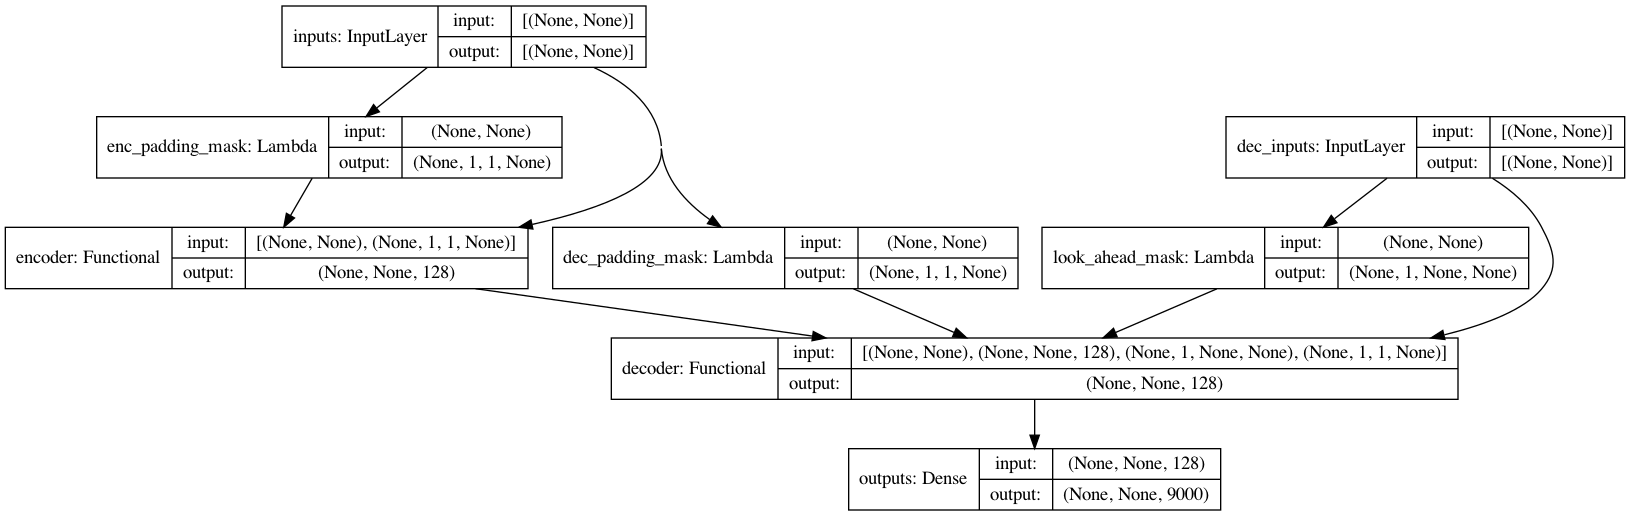

In [24]:
transformer = transformer(
    vocab_size = 20000,
    num_layers = 4,
    FFN = 512,
    d_model = 128,
    heads = 8,
    dropout = 0.3,
    name="small_transformer")

tf.keras.utils.plot_model(small_transformer, to_file='small_transformer.png', show_shapes=True)